In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 20
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

In [90]:
star = np.arange(num_obs)
# table = pd.concat(
#     {
#         "Truth": pd.DataFrame({"$d$": d, r"$\mathrm{V}$": abs_mag}, index=star),
#         "Observed": pd.DataFrame({r"$\varpi$": par_obs, r"$\mathrm{v}$": mag_obs}, index=star)
#     },
#     axis=1
# )
table = pd.DataFrame(
    {
        "$d_\mathrm{true}$": d,
        r"$\mathrm{V_{true}}$": abs_mag,
        r"$\varpi_\mathrm{true}$": par, 
        r"$\mathrm{v_{true}}$": mag,
        r"$\varpi_\mathrm{obs}$": par_obs, 
        r"$\mathrm{v_{obs}}$": mag_obs,
    }, 
    index=star
)
table.index.name = "Star"
table

,$d_\mathrm{true}$,$\mathrm{V_{true}}$,$\varpi_\mathrm{true}$,$\mathrm{v_{true}}$,$\varpi_\mathrm{obs}$,$\mathrm{v_{obs}}$
Star,,,,,,
0,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,10.173046,0.309822,0.098299,5.347077,0.092023,5.352257
2,10.120465,-0.684417,0.098810,4.341586,0.105925,4.364776
3,9.895651,0.753958,0.101054,5.731180,0.115520,5.987240
4,10.102282,0.700781,0.098988,5.722878,0.096356,5.645176
5,10.033394,0.248704,0.099667,5.255944,0.096783,5.215395
6,9.994866,0.517101,0.100051,5.515985,0.094555,5.511034
7,10.087668,-3.275228,0.099131,1.743726,0.099190,1.781164
8,10.211624,-0.405319,0.097928,4.640155,0.087589,4.681563


In [97]:
stable = table.style.format(
    {r"$\varpi_\mathrm{"+i+"}$": "{:.5f}" for i in ["true", "obs"]}, 
    precision=4
)
stable.to_latex(
    "../tables/hbm-data.tex",
    column_format="r|rrrr|rr",
    hrules=True,
)
stable

,$d_\mathrm{true}$,$\mathrm{V_{true}}$,$\varpi_\mathrm{true}$,$\mathrm{v_{true}}$,$\varpi_\mathrm{obs}$,$\mathrm{v_{obs}}$
Star,,,,,,
0,9.9590,-1.2758,0.10041,3.7153,0.09439,3.5628
1,10.1730,0.3098,0.09830,5.3471,0.09202,5.3523
2,10.1205,-0.6844,0.09881,4.3416,0.10593,4.3648
3,9.8957,0.7540,0.10105,5.7312,0.11552,5.9872
4,10.1023,0.7008,0.09899,5.7229,0.09636,5.6452
5,10.0334,0.2487,0.09967,5.2559,0.09678,5.2154
6,9.9949,0.5171,0.10005,5.5160,0.09456,5.5110
7,10.0877,-3.2752,0.09913,1.7437,0.09919,1.7812
8,10.2116,-0.4053,0.09793,4.6402,0.08759,4.6816


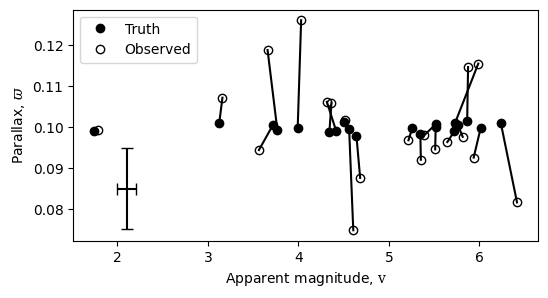

In [100]:
with plt.rc_context({"mathtext.fontset": "dejavuserif"}):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(mag, par, "ok", label="Truth")
    ax.plot(mag_obs, par_obs, "ok", markerfacecolor="none", label="Observed")
    ax.plot(np.stack([mag, mag_obs]), np.stack([par, par_obs]), "k")
    ax.errorbar(2.1, 0.085, xerr=sigma_mag, yerr=sigma_par, color="k", capsize=4)

    ax.set_xlabel(r"Apparent magnitude, $\mathrm{v}$")
    ax.set_ylabel(r"Parallax, $\varpi$")
    ax.legend(loc="upper left")

In [4]:
def simple_model(par_obs=None, mag_obs=None):
    d = numpyro.sample("d", dist.Uniform(0., 20.), sample_shape=shape)
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [5]:
sampler = NUTS(simple_model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [6]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [7]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 abs_mag[0]     -1.63      0.26     -1.62     -2.07     -1.22  11197.72      1.00
 abs_mag[1]      0.11      0.27      0.12     -0.34      0.53  10787.13      1.00
 abs_mag[2]     -0.56      0.24     -0.55     -0.94     -0.17  13126.09      1.00
 abs_mag[3]      1.26      0.22      1.27      0.90      1.61  12129.92      1.00
 abs_mag[4]      0.50      0.25      0.51      0.10      0.92   8989.79      1.00
 abs_mag[5]      0.08      0.26      0.09     -0.33      0.50   8988.12      1.00
 abs_mag[6]      0.32      0.26      0.34     -0.10      0.74   6069.55      1.00
 abs_mag[7]     -3.29      0.24     -3.28     -3.69     -2.89  12376.56      1.00
 abs_mag[8]     -0.68      0.28     -0.67     -1.13     -0.21   7373.42      1.00
 abs_mag[9]     -0.50      0.25     -0.49     -0.92     -0.11  10738.26      1.00
abs_mag[10]     -0.50      0.21     -0.49     -0.84     -0.17  14061.76      1.00
abs_mag[11]    

In [8]:
coords = {"Star": np.arange(num_obs)}
dims = {
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}

samples_simple = mcmc.get_samples()
data_simple = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_simple

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

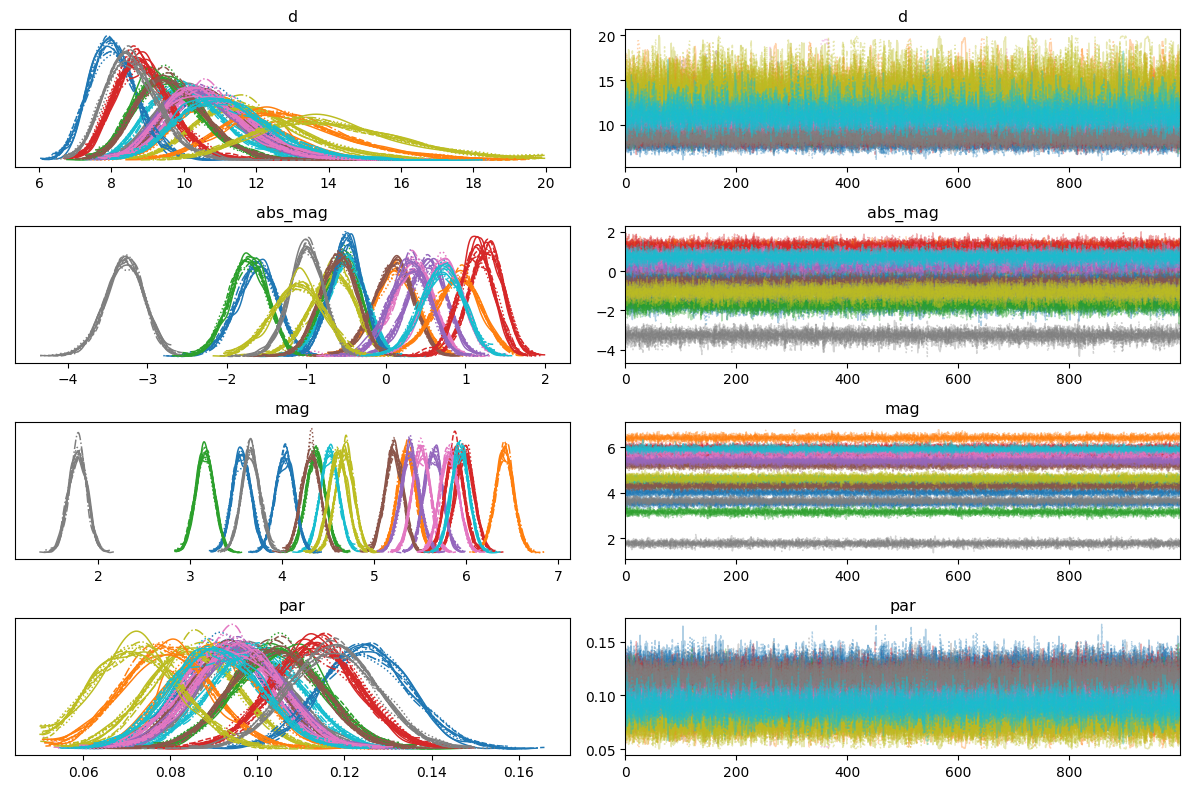

In [9]:
var_names = ["d", "abs_mag", "mag", "par"]
ax = az.plot_trace(data_simple, var_names=var_names)
plt.gcf().tight_layout()

In [10]:
def hierarchical_model(par_obs=None, mag_obs=None):
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    # sigma_d = numpyro.deterministic("sigma_d", jnp.exp(log_sigma_d))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [11]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [12]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      _d[0]      0.11      0.97      0.10     -1.38      1.81  11275.67      1.00
      _d[1]      0.14      0.99      0.15     -1.40      1.85  11341.00      1.00
      _d[2]     -0.10      0.98     -0.09     -1.76      1.48  12178.14      1.00
      _d[3]     -0.25      1.00     -0.26     -1.83      1.44   8919.97      1.00
      _d[4]      0.08      0.96      0.08     -1.48      1.69  13077.55      1.00
      _d[5]      0.05      0.99      0.05     -1.64      1.60  12173.30      1.00
      _d[6]      0.09      0.98      0.10     -1.48      1.75  11392.13      1.00
      _d[7]      0.01      0.97      0.00     -1.60      1.54  13689.35      1.00
      _d[8]      0.22      0.98      0.23     -1.36      1.82  11678.97      1.00
      _d[9]     -0.02      0.98     -0.04     -1.60      1.63  12981.59      1.00
     _d[10]     -0.46      1.04     -0.47     -2.17      1.25   5627.76      1.00
     _d[11]    

In [14]:
dims["_d"] = ["Star"]

samples_hbm = mcmc.get_samples()
data_hbm = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_hbm

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

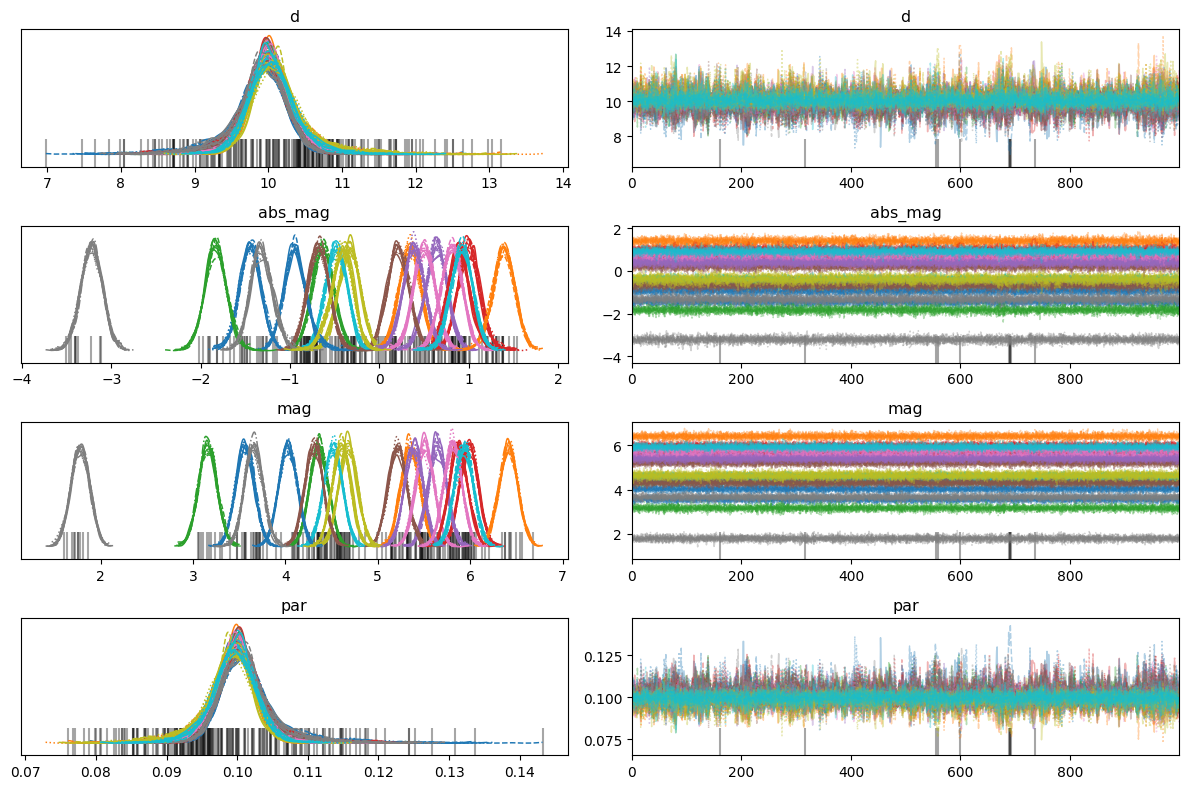

In [15]:
ax = az.plot_trace(data_hbm, var_names=var_names)
plt.gcf().tight_layout()

In [16]:
df = pd.concat(
    {
        "Simple": data_simple.posterior.to_dataframe(), 
        "HBM": data_hbm.posterior.to_dataframe()
    },
    names=["Model"]
).reset_index()
df.head()


,Model,chain,draw,Star,abs_mag,d,mag,par,_d,mu_d,sigma_d
0,Simple,0,0,0,-1.383514,9.679202,3.545684,0.103314,NaN,NaN,NaN
1,Simple,0,0,1,0.261654,10.565301,5.381063,0.094649,NaN,NaN,NaN
2,Simple,0,0,2,-0.670740,10.380713,4.410396,0.096332,NaN,NaN,NaN
3,Simple,0,0,3,1.490865,8.749432,6.200764,0.114293,NaN,NaN,NaN
4,Simple,0,0,4,0.573742,10.325767,5.643353,0.096845,NaN,NaN,NaN


TODO: Consider common_norm=False in KDE.

In [73]:
def plot_summary(df, y, truth=None, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()

    ax = sns.violinplot(
        df, x="Star", y=y, hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    if truth is not None:
        star = np.arange(num_obs)
        ax.plot(star, truth, ".k", label="Truth")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y=y, hue="Model", ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

def plot_residual(df, y, truth, obs=None, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()
    
    star = np.arange(num_obs)
    truth = pd.Series(truth, index=pd.Index(star, name="Star"))
    df = df.copy().set_index("Star")
    df.loc[truth.index, y] -= truth
    df = df.reset_index()
    ax = sns.violinplot(
        df, x="Star", y=y, hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    if obs is not None:
        ax.plot(star, obs-truth, ".k", label="Observed", markerfacecolor="none")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y=y, hue="Model", fill=True, ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

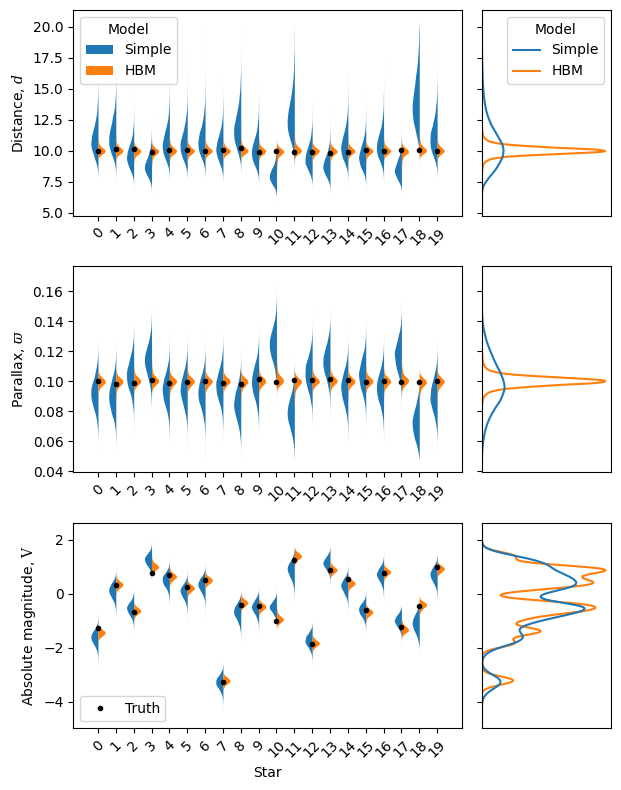

In [65]:
labelrotation = 45
with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    fig, axes = plt.subplots(3, 2, figsize=(6.4, 8), sharey="row",
                            gridspec_kw={"width_ratios": [3, 1]})

    ax0 = axes[-1]
    _, ax0 = plot_summary(df, "abs_mag", truth=abs_mag, ylabel=r"Absolute magnitude, $\mathrm{V}$", axes=ax0, legend=False)
    ax0[0].legend(handles=[ax0[0].get_lines()[-1]], loc="lower left")
    ax0[0].tick_params(axis='x', labelrotation=labelrotation, )
    
    ax = axes[-2]
    ax[0].sharex(ax0[0])
    _, ax = plot_summary(df, "par", truth=par, ylabel=r"Parallax, $\varpi$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelrotation=labelrotation)

    ax = axes[-3]
    ax[0].sharex(ax0[0])
    _, ax = plot_summary(df, "d", truth=d, ylabel=r"Distance, $d$", axes=ax)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelrotation=labelrotation)

    fig.tight_layout()
#     fig.savefig("../figures/hbm-results.pdf", format="pdf", dpi=300)

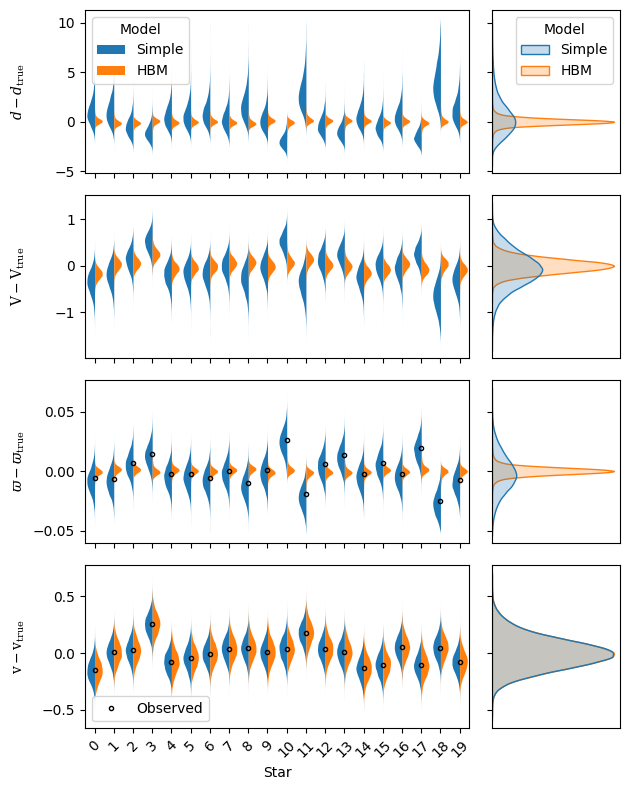

In [78]:
labelrotation = 45
with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    fig, axes = plt.subplots(4, 2, figsize=(6.4, 8), sharey="row",
                            gridspec_kw={"width_ratios": [3, 1]})

    ax0 = axes[-1]
    _, ax0 = plot_residual(df, "mag", mag, obs=mag_obs, ylabel=r"$\mathrm{v} - \mathrm{v_{true}}$", axes=ax0, legend=False)
    ax0[0].tick_params(axis='x', labelrotation=labelrotation)
    ax0[0].legend(handles=[ax0[0].get_lines()[-1]], loc="lower left")

    ax = axes[-2]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "par", par, obs=par_obs, ylabel=r"$\varpi - \varpi_\mathrm{true}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-3]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "abs_mag", abs_mag, ylabel=r"$\mathrm{V} - \mathrm{V_{true}}$", axes=ax, legend=False)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)

    ax = axes[-4]
    ax[0].sharex(ax0[0])
    _, ax = plot_residual(df, "d", d, ylabel=r"$d - d_\mathrm{true}$", axes=ax)
    ax[0].set_xlabel(None)
    ax[0].tick_params(axis='x', labelbottom=False)
    fig.align_ylabels()
    fig.tight_layout()
    fig.savefig("../figures/hbm-results.pdf", format="pdf", dpi=300)

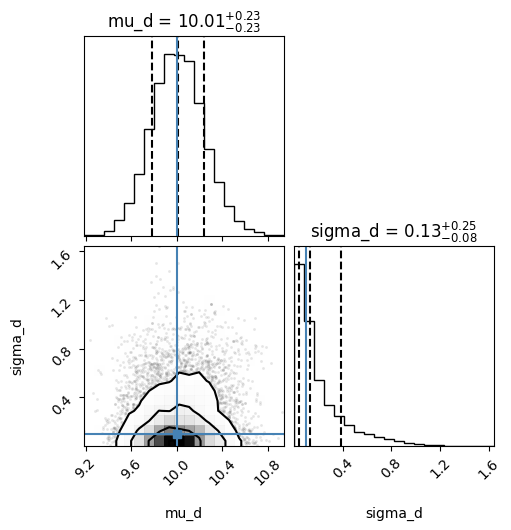

In [29]:
fig = corner(
    data_hbm, 
    var_names=["mu_d", "sigma_d"], 
    truths={"mu_d": mu_d, "sigma_d": sigma_d},
    show_titles=True,
    quantiles=[.16, .5, .84]
)

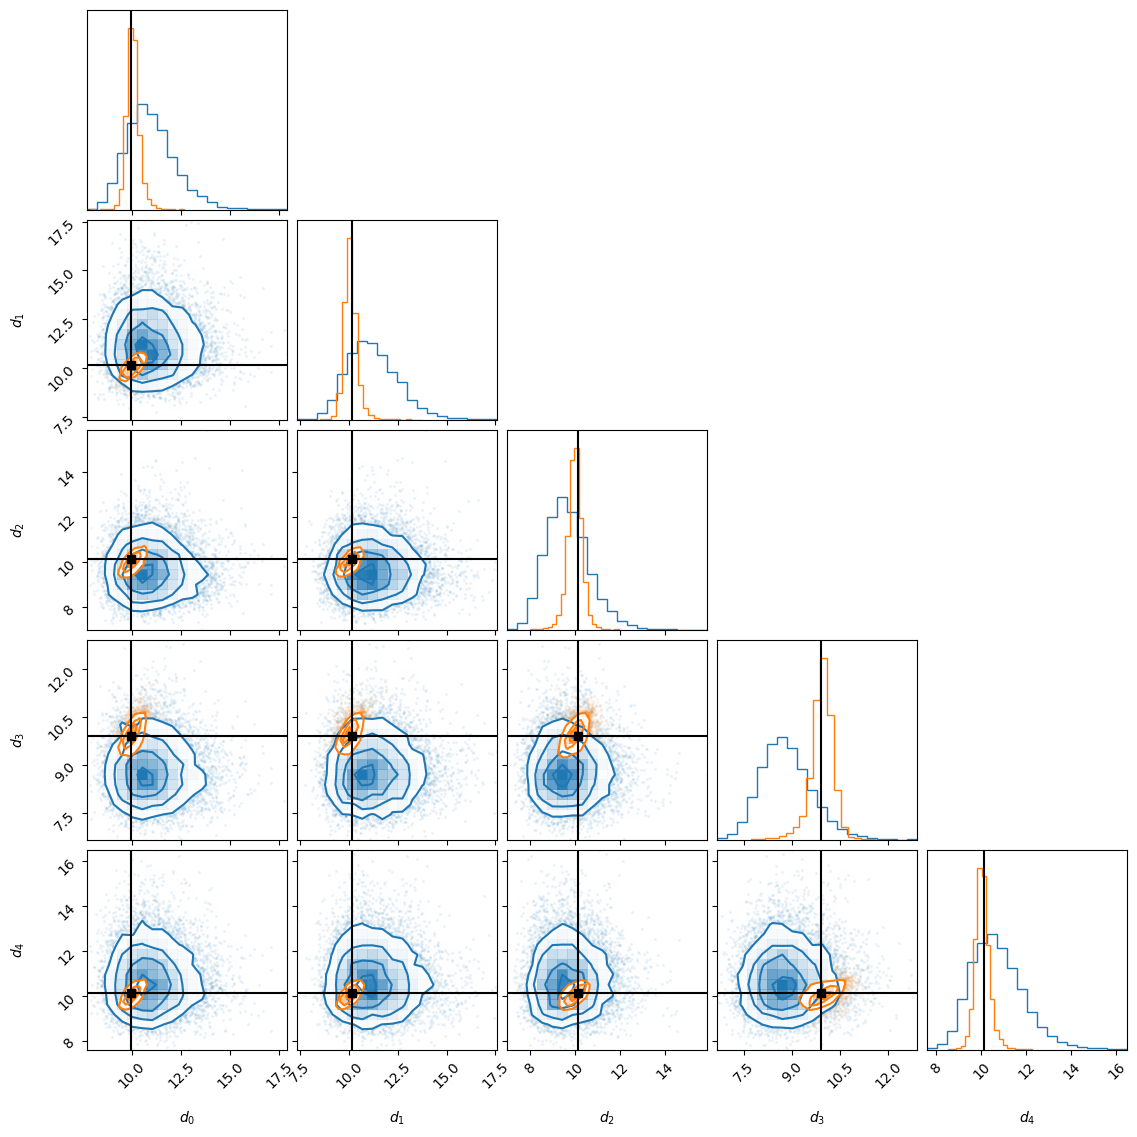

In [30]:
stars = np.arange(5)
var_names = ["d"]
labels = [f"$d_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"d": d[stars]},
    truth_color="k",
    fig=fig
)

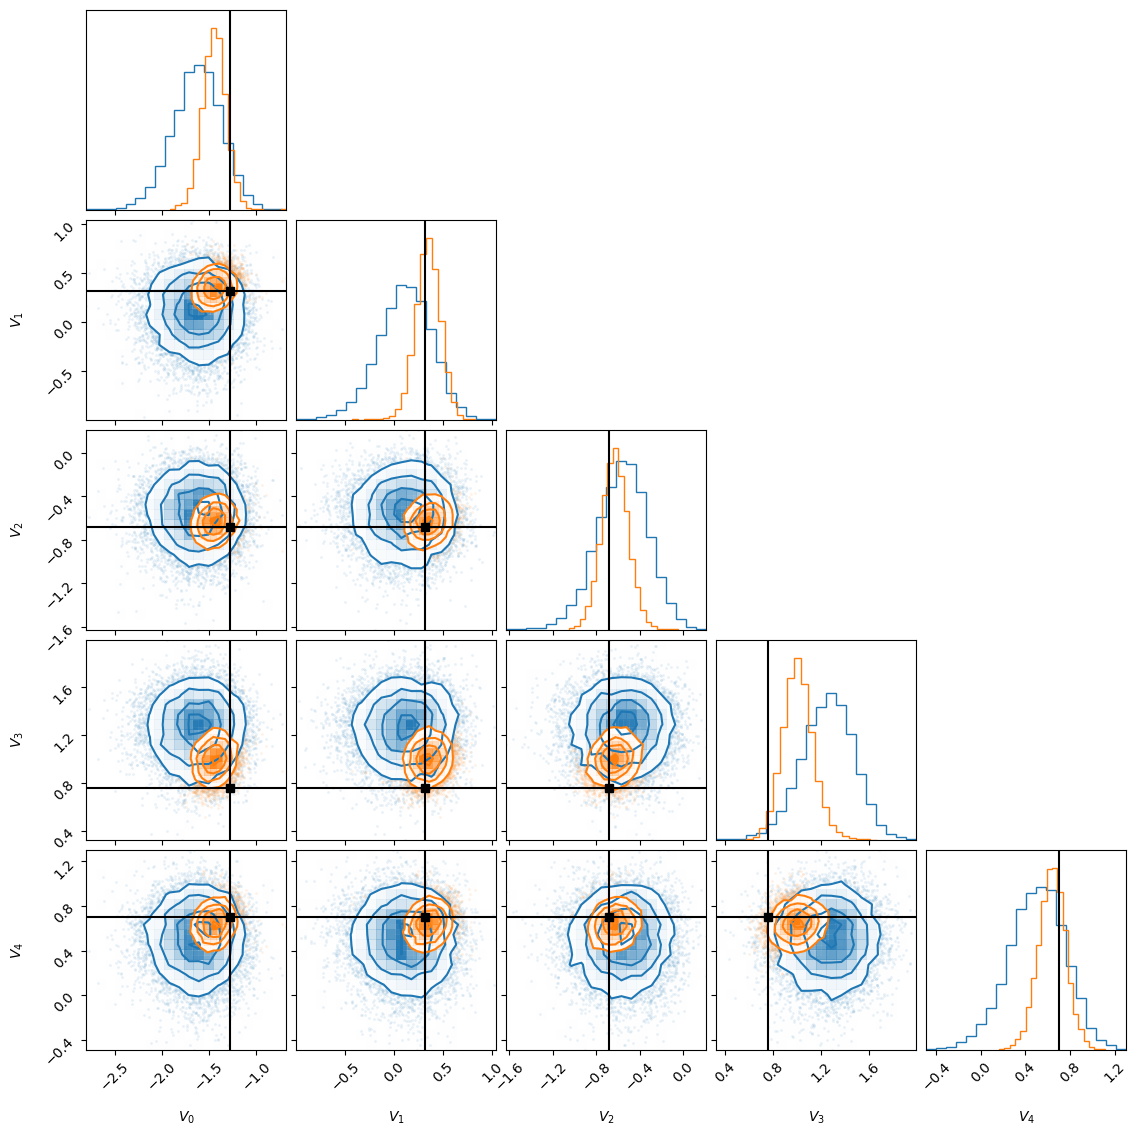

In [31]:
stars = np.arange(5)
var_names = ["abs_mag"]
labels = [f"$V_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"abs_mag": abs_mag[stars]},
    truth_color="k",
    fig=fig
)

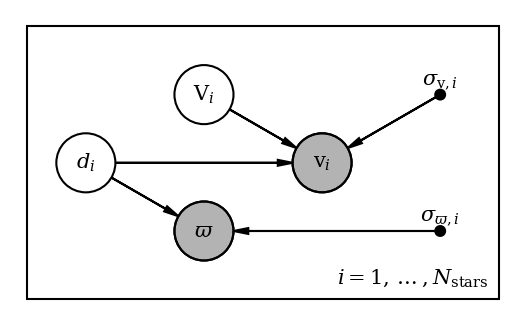

In [34]:
ux = 1
uy = 1 / np.sqrt(3)
plot_params = {"facecolor": "white"}

with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    # Instantiate the PGM.
    pgm = daft.PGM()

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", ux, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    pgm.render(dpi=150)
    pgm.savefig("../figures/simple-pgm.pdf", format="pdf", dpi=300)

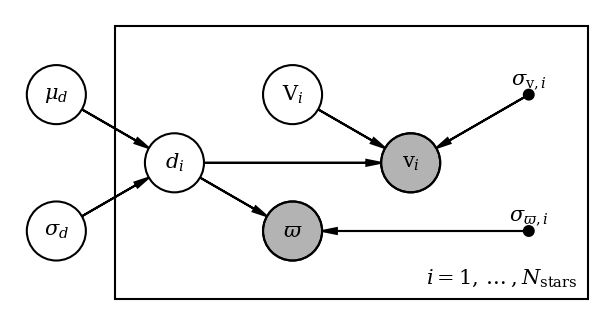

In [36]:
# Instantiate the PGM.
with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    pgm = daft.PGM()

    # Hyperparameters
    pgm.add_node("mu_d", r"$\mu_d$", -ux, uy, plot_params=plot_params)
    pgm.add_node("sigma_d", r"$\sigma_d$", -ux, -uy, plot_params=plot_params)

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", 1, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("mu_d", "d")
    pgm.add_edge("sigma_d", "d")

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    pgm.render(dpi=150)
    pgm.savefig("../figures/hbm-pgm.pdf", format="pdf", dpi=300)

<Axes: >

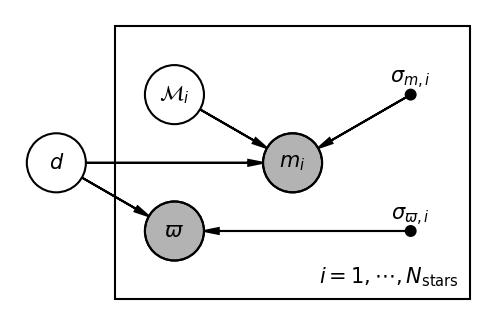

In [185]:
# Instantiate the PGM.
pgm = daft.PGM()

# Parameters
pgm.add_node("d", r"$d$", 0, 0)
pgm.add_node("abs_mag", r"$\mathcal{M}_i$", ux, uy)
pgm.add_node("mag", r"$m_i$", 2*ux, 0, observed=True)
pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

# Uncertainties
pgm.add_node("sigma_mag", r"$\sigma_{m,i}$", 3*ux, uy, fixed=True)
pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)

pgm.add_edge("d", "mag")
pgm.add_edge("d", "par")
pgm.add_edge("abs_mag", "mag")
pgm.add_edge("sigma_mag", "mag")
pgm.add_edge("sigma_par", "par")

pgm.add_plate([ux/2, -2*uy, 3*ux, 4*uy], label=r"$i=1,\cdots,N_\mathrm{stars}$", 
              position='bottom right')
pgm.render(dpi=150)